In [1]:
import sys
import os

# If your notebook is in the same directory as the 'data_collector' module, you can use:
# root_path = os.getcwd()

# If you need to go up one directory from the notebook's location, you can use:
root_path = os.path.dirname(os.getcwd())

sys.path.append(root_path)

import pandas as pd
import numpy as np

import sqlite3

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from processing.processing_utils import MatchHistory


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('/Users/admin/.matplotlib/mpl_configdir/stylelib/rose-pine-moon.mplstyle')

from data_collection.data_collector import DataCollector


In [2]:
conn = sqlite3.connect("/Users/admin/git_projects/football/data_collection/data/serie_a.db")
query = "SELECT * FROM serie_a_data"
df = pd.read_sql_query(query, conn)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

/var/folders/cz/tsrtpglj4x3fc4dskw2pnjrc0000gn/T/ipykernel_4649/3965881410.py:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


In [3]:
df

,game_id,Div,Date,HomeTeam,AwayTeam,TG,FTHG,FTAG,FTR,HTHG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,city_name,lat,lon
0,0c3926d4,serie_a,2003-08-30,Reggina,Sampdoria,4.0,2.0,2.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Reggio Calabria,38.103539,15.639756
1,32c4721c,serie_a,2003-08-31,Bologna,Parma,4.0,2.0,2.0,D,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Bologna,44.493820,11.342633
2,740eeac7,serie_a,2003-08-31,Brescia,Chievo,2.0,1.0,1.0,D,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Brescia,45.779580,10.425873
3,dbe6a3b4,serie_a,2003-08-31,Inter,Modena,2.0,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Milano,45.464194,9.189635
4,c7595482,serie_a,2003-08-31,Juventus,Empoli,6.0,5.0,1.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Torino,45.067755,7.682489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7618,16649a39,serie_a,2024-03-16,Frosinone,Lazio,5.0,2.0,3.0,A,1.0,...,1.94,1.98,2.00,2.00,1.94,1.92,2023/2024,Frosinone,41.628547,13.575850
7619,2c251bc8,serie_a,2024-03-17,Juventus,Genoa,0.0,0.0,0.0,D,0.0,...,1.88,2.05,1.94,2.09,1.87,2.01,2023/2024,Torino,45.067755,7.682489
7620,ca2764aa,serie_a,2024-03-17,Verona,Milan,4.0,1.0,3.0,A,0.0,...,1.83,2.11,1.88,2.22,1.79,2.11,2023/2024,Verona,45.438496,10.992412
7621,3495875f,serie_a,2024-03-17,Roma,Sassuolo,1.0,1.0,0.0,H,0.0,...,2.01,1.92,2.01,2.00,1.95,1.91,2023/2024,Roma,41.893320,12.482932


In [4]:
df['Date'].dt.year.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype=int32)

In [5]:
df.tail()

,game_id,Div,Date,HomeTeam,AwayTeam,TG,FTHG,FTAG,FTR,HTHG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,city_name,lat,lon
7618,16649a39,serie_a,2024-03-16,Frosinone,Lazio,5.0,2.0,3.0,A,1.0,...,1.94,1.98,2.00,2.00,1.94,1.92,2023/2024,Frosinone,41.628547,13.575850
7619,2c251bc8,serie_a,2024-03-17,Juventus,Genoa,0.0,0.0,0.0,D,0.0,...,1.88,2.05,1.94,2.09,1.87,2.01,2023/2024,Torino,45.067755,7.682489
7620,ca2764aa,serie_a,2024-03-17,Verona,Milan,4.0,1.0,3.0,A,0.0,...,1.83,2.11,1.88,2.22,1.79,2.11,2023/2024,Verona,45.438496,10.992412
7621,3495875f,serie_a,2024-03-17,Roma,Sassuolo,1.0,1.0,0.0,H,0.0,...,2.01,1.92,2.01,2.00,1.95,1.91,2023/2024,Roma,41.893320,12.482932
7622,bb26d60f,serie_a,2024-03-17,Inter,Napoli,2.0,1.0,1.0,D,1.0,...,2.02,1.91,2.02,1.96,1.95,1.92,2023/2024,Milano,45.464194,9.189635


## Distributions

In [6]:
df.head()

,game_id,Div,Date,HomeTeam,AwayTeam,TG,FTHG,FTAG,FTR,HTHG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,city_name,lat,lon
0,0c3926d4,serie_a,2003-08-30,Reggina,Sampdoria,4.0,2.0,2.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Reggio Calabria,38.103539,15.639756
1,32c4721c,serie_a,2003-08-31,Bologna,Parma,4.0,2.0,2.0,D,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Bologna,44.493820,11.342633
2,740eeac7,serie_a,2003-08-31,Brescia,Chievo,2.0,1.0,1.0,D,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Brescia,45.779580,10.425873
3,dbe6a3b4,serie_a,2003-08-31,Inter,Modena,2.0,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Milano,45.464194,9.189635
4,c7595482,serie_a,2003-08-31,Juventus,Empoli,6.0,5.0,1.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Torino,45.067755,7.682489


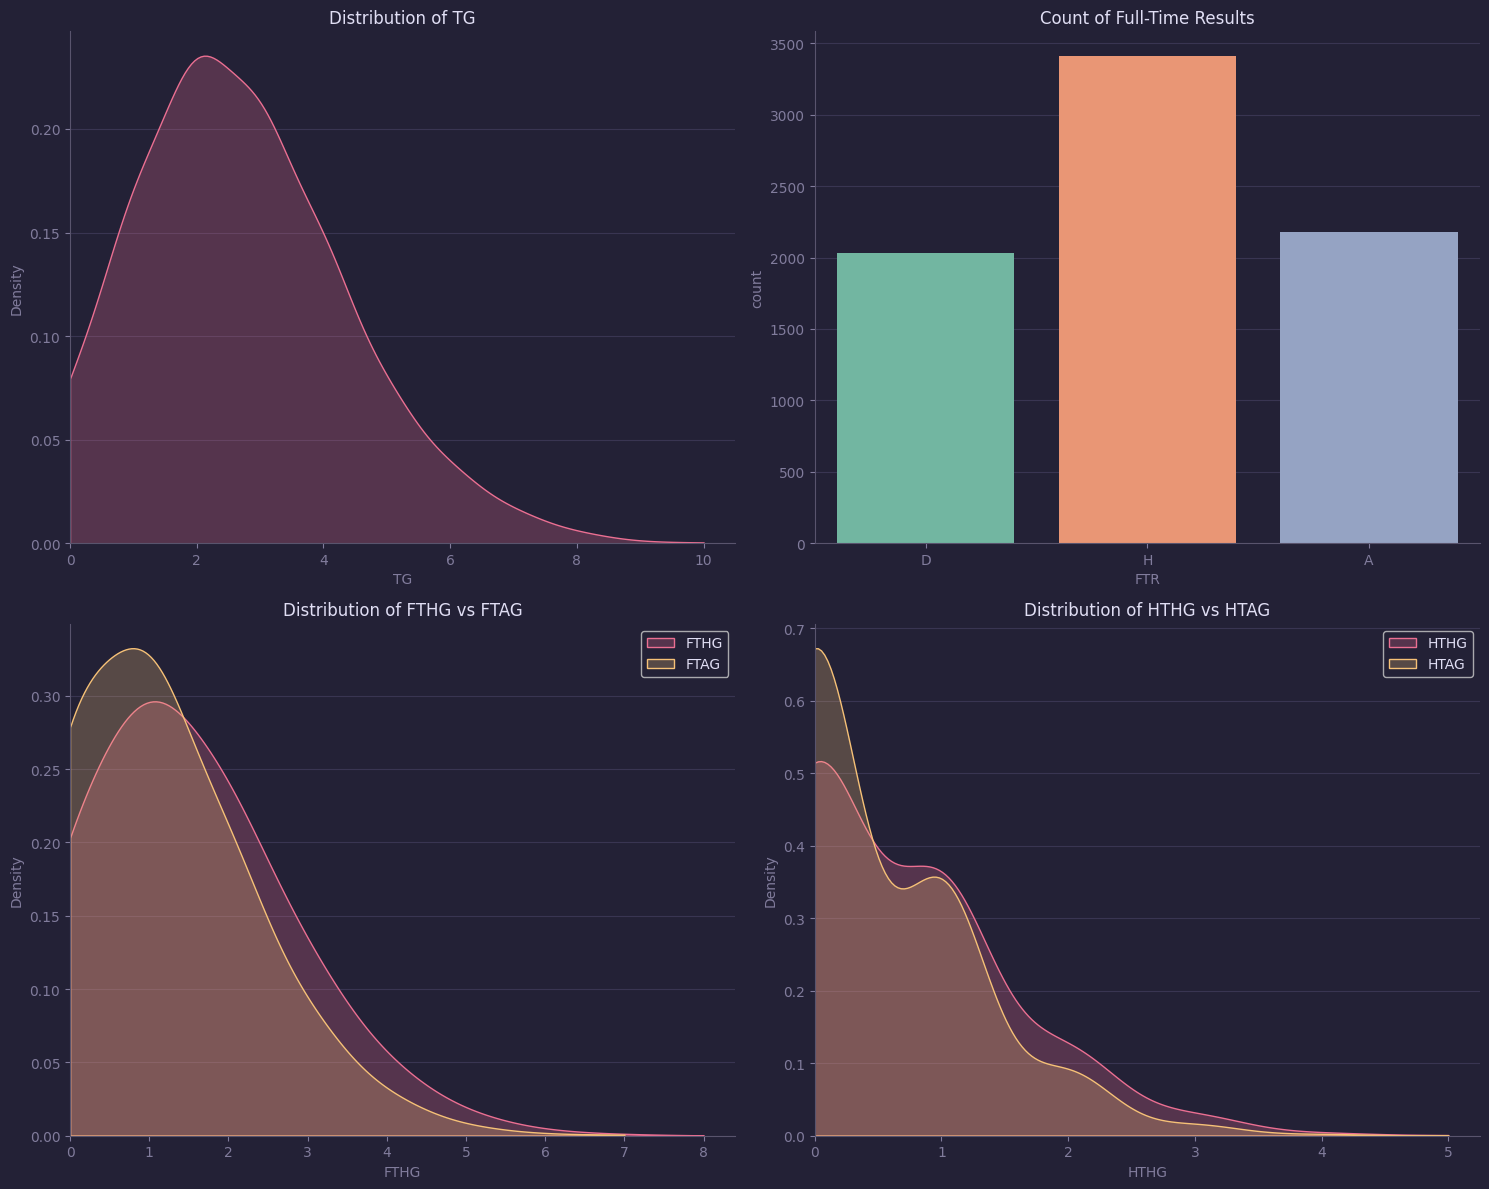

In [7]:

f, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted figsize for better visibility

# KDE plot for 'TG'
sns.kdeplot(data=df, x='TG', cut=0, bw_adjust=2, ax=axes[0, 0], fill=True)
axes[0, 0].set_xlim(left=0)
axes[0, 0].set_title('Distribution of TG')

# Count plot for 'FTR'
sns.countplot(data=df, x='FTR', hue='FTR', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Count of Full-Time Results')


sns.kdeplot(data=df, x='FTHG', ax=axes[1, 0], cut=0, bw_adjust=3, fill=True, label='FTHG')
sns.kdeplot(data=df, x='FTAG', ax=axes[1, 0], cut=0, bw_adjust=3, fill=True, label='FTAG')
axes[1, 0].set_xlim(left=0)
axes[1, 0].set_title('Distribution of FTHG vs FTAG')
axes[1, 0].legend()

sns.kdeplot(data=df, x='HTHG', ax=axes[1, 1], cut=0, bw_adjust=3, fill=True, label='HTHG')
sns.kdeplot(data=df, x='HTAG', ax=axes[1, 1], cut=0, bw_adjust=3, fill=True, label='HTAG')
axes[1, 1].set_xlim(left=0)
axes[1, 1].set_title('Distribution of HTHG vs HTAG')
axes[1, 1].legend()


# You can add another plot in axes[1, 1] as needed

plt.tight_layout()
plt.show()

<Axes: xlabel='HomeTeam', ylabel='TG'>

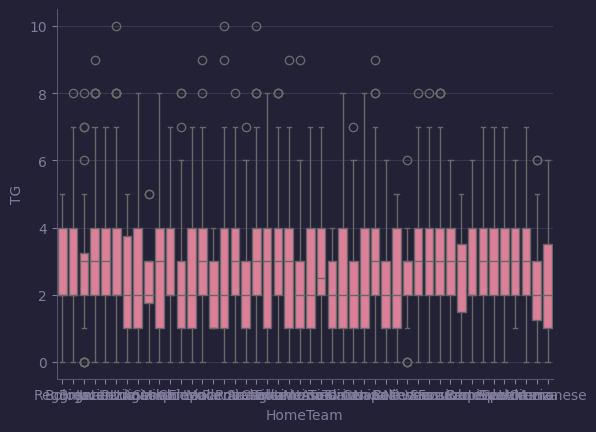

In [8]:
sns.boxplot(x=df['HomeTeam'], y=df['TG'])

## Weather Data

In [9]:
weather = pd.read_csv("/Users/admin/git_projects/football/data_collection/data/weather_test.csv")
weather.head()

/var/folders/cz/tsrtpglj4x3fc4dskw2pnjrc0000gn/T/ipykernel_4649/1832362770.py:1: DtypeWarning: Columns (49,95) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv("/Users/admin/git_projects/football/data_collection/data/weather_test.csv")


,game_id,Div,Date,HomeTeam,TG,AwayTeam,FTHG,FTAG,FTR,HTHG,...,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,solarradiation,conditions
0,9756db2e,serie_a,2003-08-30,Reggina,4.0,Sampdoria,2.0,2.0,D,2.0,...,37.49,21.1,0.0,29.5,360.0,1012.9,10.0,NaN,NaN,Clear
1,e4604038,serie_a,2003-08-31,Bologna,4.0,Parma,2.0,2.0,D,1.0,...,22.71,8.1,0.0,31.3,230.0,1007.1,11.0,50.2,NaN,Partially cloudy
2,e4be3e26,serie_a,2003-08-31,Brescia,2.0,Chievo,1.0,1.0,D,0.0,...,29.58,9.6,0.0,12.4,248.0,1007.1,11.0,49.6,NaN,Partially cloudy
3,22af961b,serie_a,2003-08-31,Inter,2.0,Modena,2.0,0.0,H,0.0,...,29.70,11.0,0.0,24.9,326.0,1007.2,11.0,30.5,NaN,Partially cloudy
4,e6bf6b52,serie_a,2003-08-31,Juventus,6.0,Empoli,5.0,1.0,H,1.0,...,24.55,2.1,0.0,14.1,354.0,1010.2,10.1,30.0,NaN,Partially cloudy


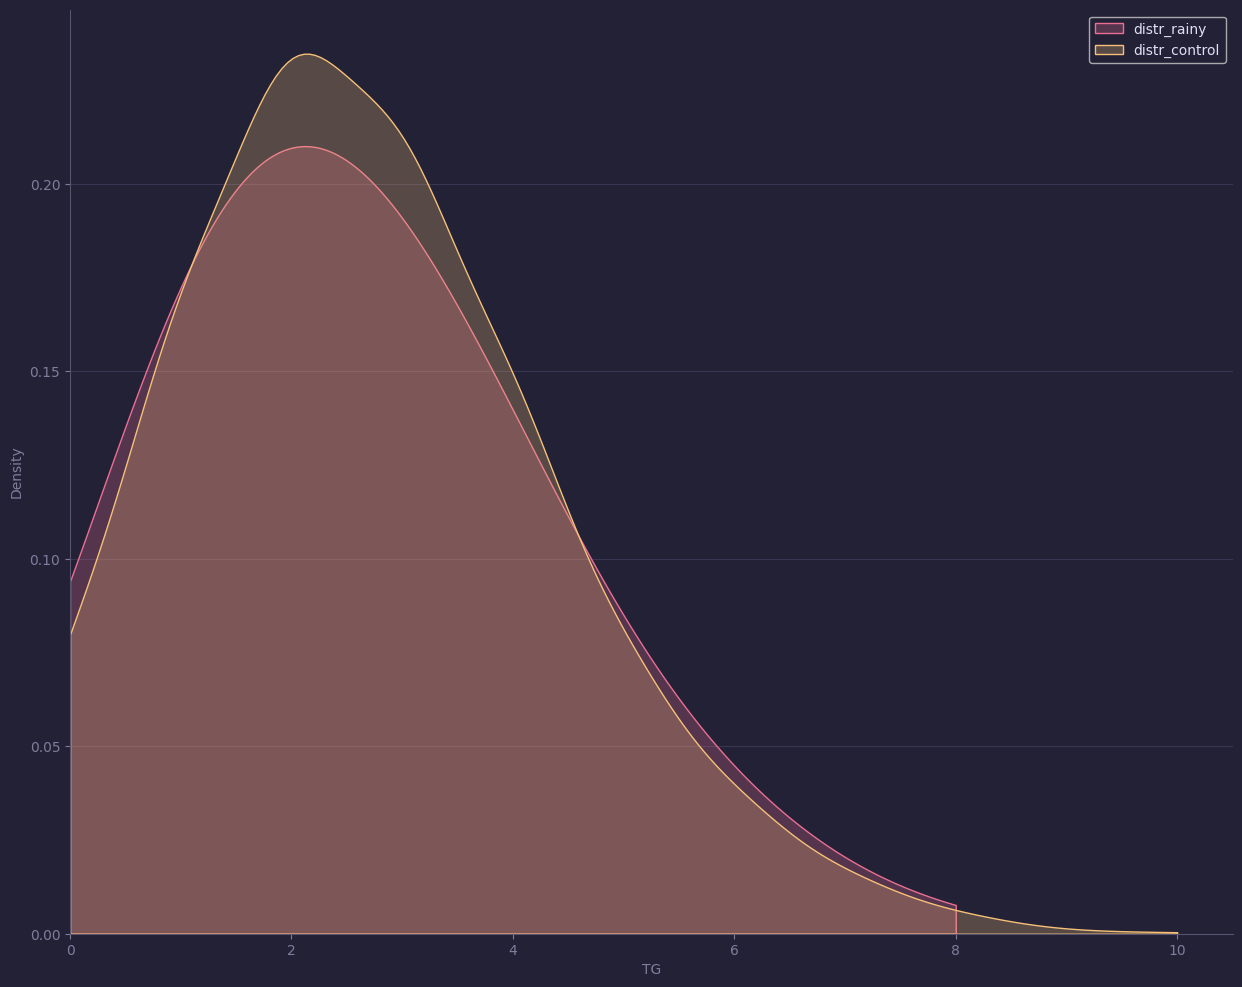

In [10]:
f, ax = plt.subplots(1, 1, figsize=(15, 12)) 

sns.kdeplot(data=weather.query("precip > 0.5"), x='TG', cut=0, bw_adjust=2, ax=ax, fill=True, label='distr_rainy')
sns.kdeplot(data=weather, x='TG', cut=0, bw_adjust=2, ax=ax, fill=True, label='distr_control')
ax.set_xlim(left=0)
ax.legend()




In [11]:
# Linear Regression of TG on weather components
weather_mdl = weather.dropna(subset=['temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed',
       'winddir', 'pressure', 'visibility', 'cloudcover'])
x = weather_mdl.iloc[:, 157:-2]
y = weather_mdl.iloc[:, 4]

model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     TG   R-squared (uncentered):                   0.724
Model:                            OLS   Adj. R-squared (uncentered):              0.724
Method:                 Least Squares   F-statistic:                              1902.
Date:                Tue, 26 Mar 2024   Prob (F-statistic):                        0.00
Time:                        20:26:40   Log-Likelihood:                         -13969.
No. Observations:                7250   AIC:                                  2.796e+04
Df Residuals:                    7240   BIC:                                  2.803e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0462      0.029      1.569      0.117      -0.012       0.104
feelslike     -0.0269      0.024     -1.142      0.254      -0.073       0.019
humidity       0.0051      0.005      1.062      0.288      -0.004       0.014
dew           -0.0051      0.018     -0.282      0.778      -0.041       0.031
precip        -0.0151      0.010     -1.468      0.142      -0.035       0.005
windspeed     -0.0019      0.003     -0.742      0.458      -0.007       0.003
winddir        0.0002      0.000      0.834      0.404      -0.000       0.001
pressure       0.0021      0.000      5.050      0.000       0.001       0.003
visibility    -0.0031      0.003     -0.932      0.351      -0.010       0.003
cloudcover    -0.0007      0.001     -0.871      0.384      -0.002       0.001
==============================================================================
Omnibus:                      368.022   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              424.850
Skew:                           0.581   Prob(JB):                     5.56e-93
Kurtosis:                       3.234   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Means

In [12]:
features = ['TG','FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR','temp','humidity', 'precip', 'windspeed']
scaler = StandardScaler()

clust = weather[features].dropna()
scaler.fit(clust)
clust_scaled = scaler.fit_transform(clust)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(clust_scaled)
clust['cluster'] = clusters

Text(0, 0.5, 'Full-Time Goals (TG)')

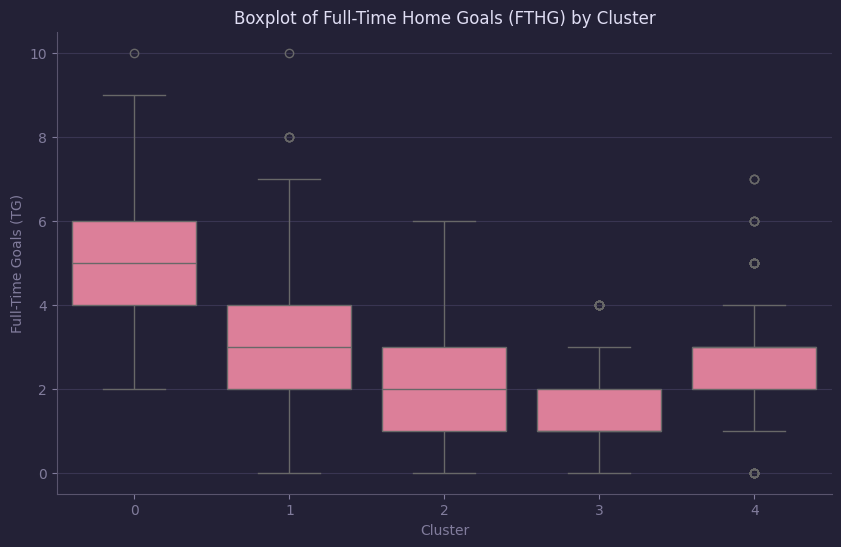

In [13]:
clust_means = (
    clust.groupby('cluster')
    .mean()
)

clust_medians = (
    clust.groupby('cluster')
    .median()
)

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='TG', data=clust)
plt.title('Boxplot of Full-Time Home Goals (FTHG) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Full-Time Goals (TG)')

In [14]:
clust_medians

,TG,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,temp,humidity,precip,windspeed
cluster,,,,,,,,,,,,,,,,,,,
0,5.0,2.0,2.0,14.0,13.0,6.0,6.0,14.0,15.0,5.0,4.0,2.0,2.0,0.0,0.0,16.90,60.380,0.0,9.4
1,3.0,2.0,1.0,19.0,8.0,8.0,3.0,13.0,13.0,8.0,3.0,1.0,2.0,0.0,0.0,14.90,64.320,0.0,8.5
2,2.0,1.0,1.0,13.0,9.0,5.0,3.0,19.0,19.0,5.0,4.0,3.0,3.0,0.0,0.0,13.80,65.570,0.0,9.3
3,1.0,1.0,0.0,12.0,10.0,4.0,3.0,14.0,14.0,5.0,4.0,2.0,2.0,0.0,0.0,16.80,59.750,0.0,9.3
4,3.0,1.0,1.0,9.0,16.0,3.0,6.0,14.0,14.0,4.0,7.0,2.0,2.0,0.0,0.0,14.45,67.405,0.0,10.8


## XGBoost

In [15]:
features = ['FTR','TG','FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'temp','humidity', 'precip', 'windspeed']
xg = weather[features].dropna(subset="HS")

epsilon = 1e-5  # A small constant to avoid division by zero

xg = (
    xg
    .assign(home_accuracy = xg['HS'] / (xg['HST'] + epsilon),
           away_accuracy = xg['AS'] / (xg['AST'] + epsilon))
)

X = xg.drop(columns=['FTR', 'FTHG', 'FTAG'])  # Exclude target and non-relevant features
y = xg['FTR']  # Target variable

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predictions
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.679236276849642


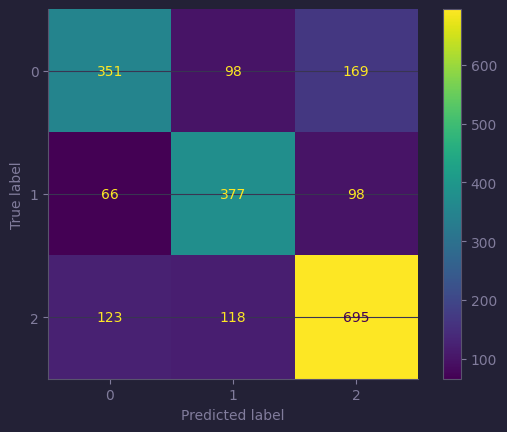

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [17]:
scores = cross_val_score(xgb_classifier, X, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-validated scores: {scores}")
print(f"Mean accuracy: {np.mean(scores)}")

Cross-validated scores: [0.65425913 0.68575519 0.70415473 0.71275072 0.66547278]
Mean accuracy: 0.6844785079775942


Text(0, 0.5, 'Feature')

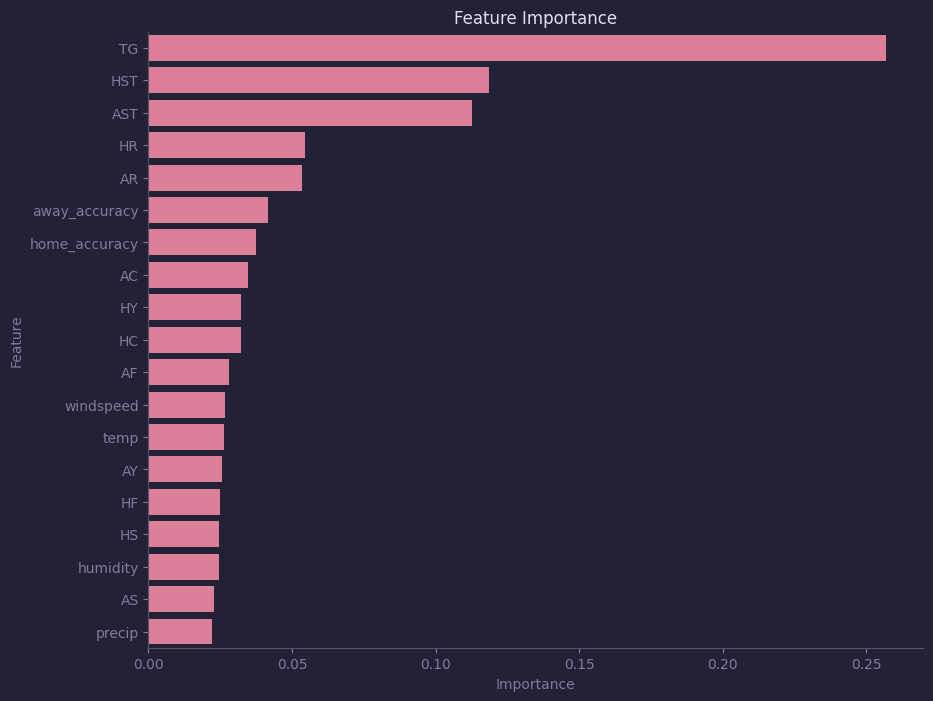

In [18]:
feature_importances = xgb_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

In [19]:
feature_importance_df

,Feature,Importance
0,TG,0.256989
1,HST,0.118532
2,AST,0.112574
3,HR,0.054446
4,AR,0.053499
5,away_accuracy,0.041594
6,home_accuracy,0.037438
7,AC,0.034844
8,HY,0.032165
9,HC,0.032162


## Visualisations

In [20]:
ht = MatchHistory(df)

In [40]:
ji = ht.one_to_one("Juventus", "Inter", total=True)

def plot_high_level_stats(df, home_team, away_team):
    # Count the occurrences of each result
    results = df['FTR'].value_counts()

    # Mapping the results to more descriptive labels
    labels = {
        'H': f'{home_team} Wins',
        'A': f'{away_team} Wins',
        'D': 'Draws'
    }
    
    # Creating the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar([labels[result] for result in results.index], results.values)
    plt.xlabel('Result')
    plt.ylabel('Counts')
    plt.title(f'{home_team} vs {away_team} - Match Results')
    plt.tight_layout()
    return plt

def plot_goals(df, home_team, away_team):
    # Total goals scored by the home team and away team
    home_goals = df[df['HomeTeam'] == home_team]['FTHG'].sum() + df[df['AwayTeam'] == home_team]['FTAG'].sum()
    away_goals = df[df['HomeTeam'] == away_team]['FTHG'].sum() + df[df['AwayTeam'] == away_team]['FTAG'].sum()

    # Creating the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar([f'{home_team} Goals', f'{away_team} Goals'], [home_goals, away_goals])
    plt.xlabel('Team')
    plt.ylabel('Goals Scored')
    plt.title(f'{home_team} vs {away_team} - Goals Scored')
    plt.tight_layout()
    return plt


<module 'matplotlib.pyplot' from '/Users/admin/git_projects/football/football/lib/python3.11/site-packages/matplotlib/pyplot.py'>

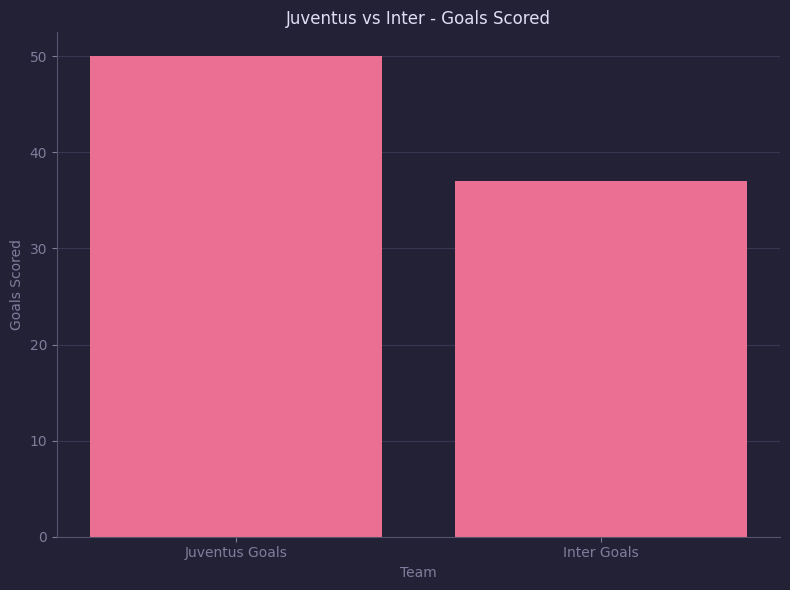

In [41]:
plot_goals(ji, "Juventus", "Inter")

<module 'matplotlib.pyplot' from '/Users/admin/git_projects/football/football/lib/python3.11/site-packages/matplotlib/pyplot.py'>

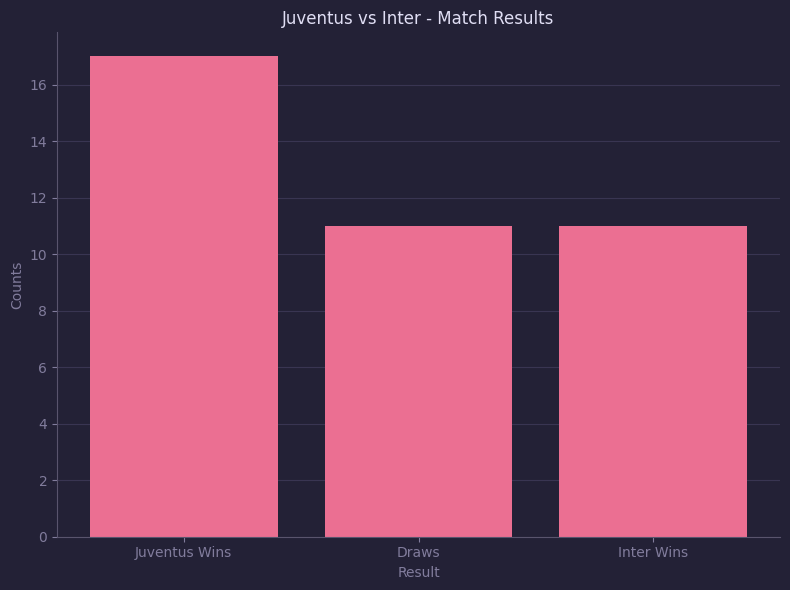

In [42]:
plot_high_level_stats(ji, "Juventus", "Inter")